In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
from numpy import log2
import math
data=pd.read_csv('decision_Tree/train.csv')
data,testdata= np.split(data,[int(0.80*len(data))])

In [3]:
class Node:
    def __init__(self,split,rows,leaf,numeric):
        self.isleaf=leaf
        self.rows=rows
        self.isnumeric=numeric
#         print("rows", rows)
        yes,no = maxfreq(rows)
       
        if yes==0 or no ==0:
            self.isleaf=True
        
        if self.isleaf==True:
            if yes>no:
                self.value=1
            else:
                self.value=0
            self.children={}
        else:
            self.value=split #name of the attribute is the value of the node
            if self.isnumeric:
                self.children,self.minsplit=partitionnumerical(rows,split)
            else:
                self.children= partitioncategorical(rows,split) #all children of this attribute in a dictionary
#         print (self.value,"Node Value")
        return
        

In [4]:
def maxfreq(rows):
    yes=0
    no=0
    for x in range(len(rows)):
        if rows.iloc[x]['left']==1:
            yes+=1
        else:
            no+=1
    return yes,no

In [5]:
def partitionnumerical(data, col):
#     print("col",col)
    countdict={}
    minent=float('inf')
    data.sort_values([col],axis=0,ascending=True,inplace=True)
    uniquevalues = data[col].unique()
    for value in uniquevalues:
        ent=0
        data1=data[data[col]<=value]
        data2=data[data[col]>value]
        data1stats = matchlabel(data1)
        data2stats = matchlabel(data2)
        
        ans=0
        for op in data1stats:
            val=data1stats[op]
            ans-= float(val)/float(len(data1)) * math.log((float(val)/float(len(data1))),2)
        
        ent+=ans*(len(data1)/len(data))
       
        ans=0
        for op in data2stats:
            val=data2stats[op]
            ans-= float(val)/float(len(data2)) * math.log((float(val)/float(len(data2))),2)
        
        ent+=ans*(len(data2)/len(data))
    
        if ent<minent:
            minent=ent
            minsplit=value
    
#     print("categorical ent",minent)
#     print("minsplit",minsplit)
#     print("minsplit at",minsplit)
    countdict[0]=data[data[col]<=minsplit]
    countdict[1]=data[data[col]>minsplit]
    return countdict,minsplit


In [6]:
#partitions the rows into multiple groups based on the column passed
def partitioncategorical(data,col):
    countdict={}
    uniquevalues = data[col].unique()
    for value in uniquevalues:
        countdict[value]= data[data[col]==value]
#     print (countdict)
    return countdict

In [7]:
#matches the passed rows to count the number of yes and no in the rows 
def matchlabel(data):
    stats={}
    values, valuecount = np.unique(data['left'],return_counts=True)
    for i in range(len(values)):
        stats[values[i]]=valuecount[i]
    return stats

In [8]:
def isnumeric(col):
    return data[col].dtype.kind in 'bifc'

In [9]:
#calculate the entropy of the passed column
def entropy(rows,col):
    entro=0
    
    if isnumeric(col):
#         print(col,"is numeric")
        countdict,minsplit=partitionnumerical(rows,col)
    else:
        countdict= partitioncategorical(rows,col)
    
#     print("countdict",countdict)
    for key in countdict:
        rowgroup=countdict[key]
        rowgroupstats=matchlabel(rowgroup)
        ans=0
#         print(rowgroupstats)
        for op in rowgroupstats:
            value=rowgroupstats[op]
            ans-= float(value)/float(len(rowgroup)) * math.log((float(value)/float(len(rowgroup))),2)
        
        entro+=ans*(len(rowgroup)/len(rows))
    return entro

In [10]:
def totalentropy(data):
    countdict=partitioncategorical(data,'left')
    total = 0
    for key in countdict:
        value=len(countdict[key])
        total-= float(value)/float(len(data)) * math.log((float(value)/float(len(data))),2)
    return total

In [11]:
def informationgain(data,total):
#     print("length of data", len(data))
    maxinfogain=0
    attr=0
    infogain=0
    for col in data:
        if col=='left': 
            continue
        ent=entropy(data,col)
#         print("Total and entropy",total,ent)
        infogain=total-ent
#         print (infogain)
        if infogain>maxinfogain:
#             print("maxinfogain",maxinfogain)
            maxinfogain=infogain
            attr=col
    return maxinfogain,attr

In [12]:
nodecount=0

In [13]:
def buildTree(data,maxlevel,level):
    global nodecount
#     print("level",level)
#     if(level>maxlevel):
#         maxlevel=level
    total=totalentropy(data)
#     print(total,"total")
    gain, split = informationgain(data,total)
#     print("split", split)
    if level == maxlevel or gain<=0:
        nodecount+=1
        return Node(split,data,True,False)
    
    root = Node(split,data,False,isnumeric(split))
#     print( "root->children",root.children)
    for child in root.children:
#         print(root.children[child].drop(columns=[split]))
        nodecount+=1
        if(isnumeric(split)):
            root.children[child]=buildTree(root.children[child],maxlevel,level+1)
        else:
            root.children[child]=buildTree(root.children[child].drop(columns=[split]),maxlevel,level+1)
    return root     

In [20]:
levels=[]
trainerror=[]
validateerror=[]
nodes=[]

for i in range(1,19):
    levels.append(i)
    root=buildTree(data,i,0)
    nodes.append(nodecount)
    print("NODE", nodecount)
    nodecount=0
    err,terr=predict(root,testdata,data)
    trainerror.append(err)
    validateerror.append(terr)
    print("error",i,err)

# print(root.isleaf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


NODE 4
error 1 0.1781979977753059
NODE 10
error 2 0.17597330367074526
NODE 19
error 3 0.05506117908787542
NODE 69
error 4 0.03303670745272525
NODE 128
error 5 0.0253615127919911
NODE 228
error 6 0.01957730812013348
NODE 343
error 7 0.015239154616240267
NODE 472
error 8 0.011568409343715239
NODE 583
error 9 0.009343715239154617
NODE 699
error 10 0.006229143492769744
NODE 775
error 11 0.00489432703003337
NODE 828
error 12 0.0036707452725250277
NODE 858
error 13 0.0023359288097886542
NODE 890
error 14 0.0014460511679644048
NODE 905
error 15 0.0010011123470522803
NODE 917
error 16 0.0006674082313681868
NODE 923
error 17 0.0005561735261401557
NODE 926
error 18 0.0002224694104560623


NameError: name 'error' is not defined

[0.1781979977753059, 0.17597330367074526, 0.05506117908787542, 0.03303670745272525, 0.0253615127919911, 0.01957730812013348, 0.015239154616240267, 0.011568409343715239, 0.009343715239154617, 0.006229143492769744, 0.00489432703003337, 0.0036707452725250277, 0.0023359288097886542, 0.0014460511679644048, 0.0010011123470522803, 0.0006674082313681868, 0.0005561735261401557, 0.0002224694104560623]


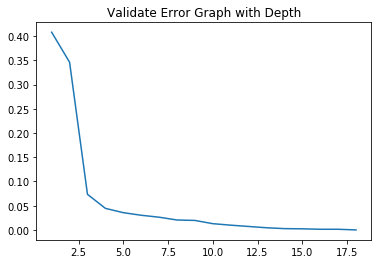

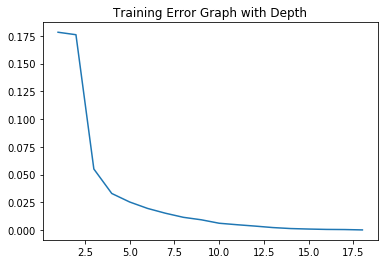

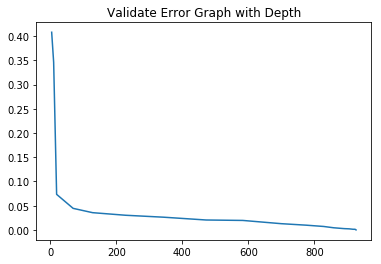

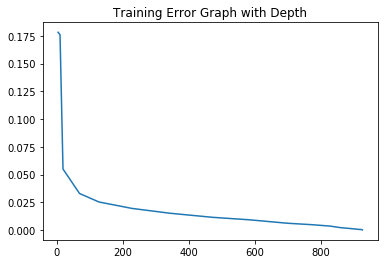

In [23]:
print(trainerror)
plot_graph(validateerror,trainerror,levels)
plot_graph(validateerror,trainerror,nodes)

In [22]:
def plot_graph(validate_error, training_error, depth):
    plt.figure()
    
    x = depth 
    y = validate_error 
    plt.title("Validate Error Graph with Depth") 

    # Plot the points using matplotlib 
    plt.plot(x, y) 
    plt.show()
    
    y = training_error 
    plt.title("Training Error Graph with Depth") 

    # Plot the points using matplotlib 
    plt.plot(x, y) 
    plt.show()

In [19]:
def findlabel(root,row):
    ptr = root
    while ptr.isleaf==False:
        if ptr.isnumeric==False:
            try:
                value=row[ptr.value]
#                 print(ptr.children)
                ptr=ptr.children[value]
            except:
                return 0
        else:
            try:
                value=row[ptr.value]
                if value<=ptr.minsplit:
                    ptr=ptr.children[0]
                else:
                    ptr=ptr.children[1]
            except:
                return 0
    
    return ptr.value

In [16]:
def calculate(fp,fn,tp,tn,wrong,correct):
    accuracy=correct/(wrong+correct)
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    f1score=(2/(1/precision)+(1/recall))
    return accuracy,recall,precision,f1score

In [17]:
def predict(root,testdata,data):
    correct=0
    wrong=0
    tcorrect=0
    twrong=0
    
    for i in range(0,len(data)):
        row=data.iloc[i]
        predictlabel=findlabel(root,row)
        if predictlabel==row['left']:
            correct+=1
        else:
            wrong+=1
            
    for i in range(0,len(testdata)):
        row=data.iloc[i]
        predictlabel=findlabel(root,row)
        if predictlabel==row['left']:
            tcorrect+=1
        else:
            twrong+=1
#     print(fp,fn,tp,tn,wrong,correct)
#     calculate(fp,fn,tp,tn,wrong,correct)
    return (wrong/(wrong+correct)),(twrong/(twrong+tcorrect)) 